The main example is from [SHAP Documentation](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/tree_explainer/NHANES%20I%20Survival%20Model.html) - I added some extra explanations and corrected some outdated code

As an extra learning material, I suggest reading [SHAP chapter](https://christophm.github.io/interpretable-ml-book/shap.html) of Interpretable Machine Learning by Christoph Molnar

## NHANES I Survival Model
This is a cox proportional hazards model on data from NHANES I<a name="footnote1-src"></a><sup>[1](#footnote1)</sup> with followup mortality data from the NHANES I Epidemiologic Followup Study. It is designed to illustrate how SHAP values enable the interpretion of XGBoost models with a clarity traditionally only provided by linear models. We see interesting and non-linear patterns in the data, which suggest the potential of this approach. 

Note that support for Cox loss and SHAP interaction effects were only recently merged, so you will need the latest master version of XGBoost to run this notebook.

---

<a name="footnote1"></a>1. [^](#footnote1-src) In the first National Health and Nutrition Examination Survey (NHANES I), data were collected from a national probability sample of the civilian non-institutionalized population. The NHANES I Epidemiologic Follow-up Study attempts to trace and interview all study subjects at their current location.

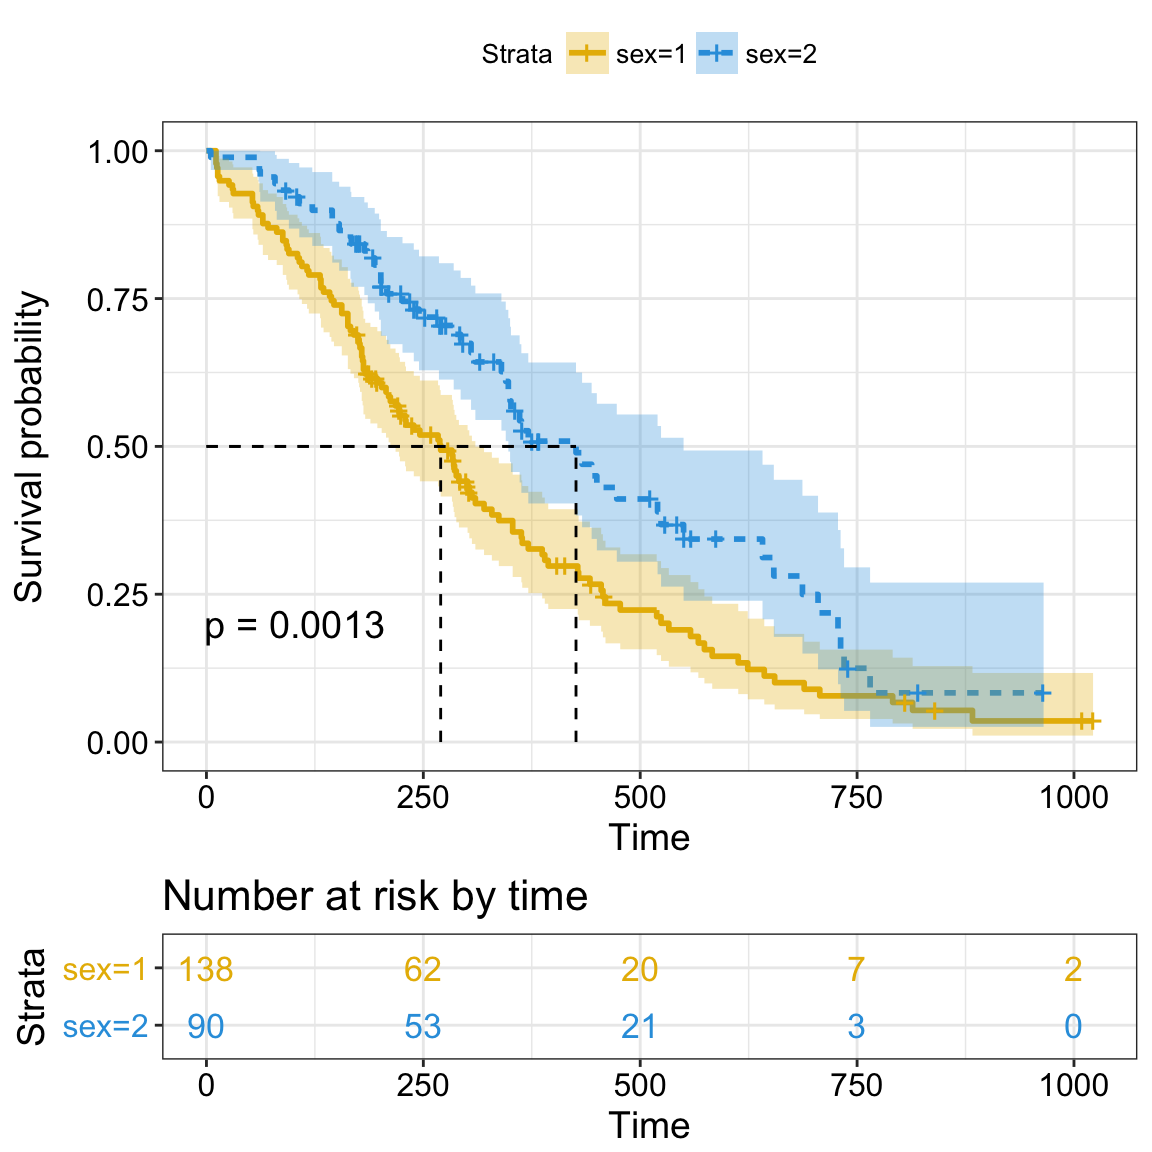

# Survival Analysis

Survival analysis is a statistical field that examines and models the time it takes for events of interest to occur, known as "time-to-event" analysis.

## Key Concepts

### Censored Data
- **Censored Data**: Observations where the event has not occurred at the end of the study or is not observed for other reasons, which is common in survival data.

### Survival Function
- **Survival Function (`S(t)`)**: Represents the probability of surviving past time `t`. It's a key function in survival analysis, showing the likelihood that the event has not occurred by a certain time.

### Hazard Function
- **Hazard Function (`λ(t)`)**: Defines the instantaneous rate at which the event is expected to happen, given no prior occurrence. It essentially reflects the risk of the event occurring at time `t`.

### Kaplan-Meier Estimator
- **Kaplan-Meier Estimator**: A non-parametric method used to estimate the survival function from life table data, accounting for censored data.

### Cox Proportional Hazards Model
- **Cox Proportional Hazards Model**: A regression model used to investigate the effect of multiple variables on survival. It assumes that the effect of the covariates on the hazard is multiplicative and constant over time.

### Life Tables
- **Life Tables**: Tabular compilations of survival statistics that allow for the examination of survival over different intervals.

## Applications

Survival analysis is vital in many fields, including:

- **Medical Research**: For assessing patient survival times and the effectiveness of treatments.
- **Engineering**: In reliability engineering to predict the life duration of materials or systems.
- **Economics**: For analyzing the time until events like job changes, purchases, or other economic behaviors occur.

In [32]:
import matplotlib.pylab as plt
import numpy as np
import shap
import xgboost
from sklearn.model_selection import train_test_split

## Create XGBoost data objects
This uses a pre-processed subset of NHANES I data available in the SHAP datasets module.

In [50]:
X, y = shap.datasets.nhanesi()
X_display, y_display = shap.datasets.nhanesi(
    display=True)  # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

## xgboost.DMatrix (for curious minds)

The `xgboost.DMatrix` is a specialized data structure used by the XGBoost library. Here's an overview of its functions:

- **Optimized Data Structure**: Designed for memory efficiency and training speed, suitable for machine learning tasks.

- **Sparse Data Handling**: Efficiently manages sparse data, which is common in many real-world datasets.

- **Data Loading**: Capable of loading data from various formats including numpy arrays, pandas data frames, and CSV files.

- **Data Preprocessing**: Handles missing values and allows for feature weighting during preprocessing.

- **Memory Efficiency**: Utilizes a sparse format internally to represent data, saving memory by storing only non-zero values.

- **Caching**: Caches data into a binary file for faster reloading, which is beneficial for large datasets.

- **Label Storage**: Stores labels for supervised learning tasks, facilitating both classification and regression models.

- **Weight Assignment**: Enables assigning weights to individual instances, useful in imbalanced datasets.

To utilize `DMatrix` in XGBoost, data is first converted into this format before being fed into the model training process, leveraging the library's optimizations for performance.


## XGBoost Model
XGBoost, which stands for eXtreme Gradient Boosting, is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It implements machine learning algorithms under the Gradient Boosting framework, providing a solution for both regression and classification problems.

## Key Features of XGBoost

### Gradient Boosting Framework
XGBoost belongs to the family of boosting algorithms which convert weak learners into strong ones. It does this by iteratively learning from the mistakes of a sequence of models.

### Regularization
It includes regularization terms (L1 and L2), which help prevent overfitting and improve model generalization.

### Scalability and Performance
XGBoost is designed to be highly scalable and can handle large datasets efficiently. It is often faster than other gradient boosting implementations.

### Handling Missing Data
XGBoost has an in-built routine to handle missing values. The model learns the best imputation value for missing data during training.

### Tree Pruning
Unlike other gradient boosting algorithms that stop splitting a node as soon as it encounters a negative loss, XGBoost will split up to the max_depth specified and then start pruning the tree backwards.

In [54]:
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params,
                            xgb_train,
                            10000,
                            evals=[(xgb_test, "test")],
                            verbose_eval=1000)

[0]	test-cox-nloglik:7.68135
[1000]	test-cox-nloglik:7.03171
[2000]	test-cox-nloglik:6.98235
[3000]	test-cox-nloglik:6.96869
[4000]	test-cox-nloglik:6.96473
[5000]	test-cox-nloglik:6.96476
[6000]	test-cox-nloglik:6.96689
[7000]	test-cox-nloglik:6.96861
[8000]	test-cox-nloglik:6.97077
[9000]	test-cox-nloglik:6.97352
[9999]	test-cox-nloglik:6.97620


### Negative Log-Likelihood (nloglik)
This is a measure of how well the model fits the data. The likelihood represents the probability of the data given the model; by taking its negative logarithm, we convert it into a quantity that can be minimized. In survival analysis, and specifically in Cox regression, the likelihood function is complex due to censoring, so specialized computations are necessary.

In [55]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params,
                      xgb_full,
                      5000,
                      evals=[(xgb_full, "test")],
                      verbose_eval=1000)

[0]	test-cox-nloglik:9.28404
[1000]	test-cox-nloglik:8.60868
[2000]	test-cox-nloglik:8.53134
[3000]	test-cox-nloglik:8.49490
[4000]	test-cox-nloglik:8.47122
[4999]	test-cox-nloglik:8.45328


## Cox Proportional Hazards Regression (for curious minds)

Cox regression is a statistical technique used in survival analysis to investigate the effect of various factors on the time it takes for a specified event to occur, often called "survival time."

## Key Concepts

### Right Censored Data
- **Right Censored**: Data where the event has not occurred by the end of the study. In XGBoost's Cox objective, negative values indicate right-censored instances.
  
### Hazard Ratio (HR)
- **Hazard Ratio**: A measure of the effect of covariates on the hazard or risk of the event. It's calculated as `HR = exp(marginal_prediction)`.
  - `HR = 1`: No effect on the risk.
  - `HR > 1`: Increased risk of the event.
  - `HR < 1`: Decreased risk of the event.

### Marginal Prediction
- **Marginal Prediction**: The model's log hazard ratio prediction before transformation to the hazard ratio scale.

### Proportional Hazard Function
- **Hazard Function**: In the Cox model, it is expressed as \( h(t) = h_0(t) \times HR \), where \( h_0(t) \) is the baseline hazard function and HR is the hazard ratio derived from covariates.

## Interpretation of Predictions
With XGBoost's Cox regression, predictions are made on the hazard ratio scale. The model outputs the log hazard, which is then exponentiated to give the hazard ratio. This ratio indicates the relative risk of the event occurring given the covariates of the model.


## Check Performance
The C-statistic measures how well we can order people by their survival time (1.0 is a perfect ordering).

In [46]:
def c_statistic_harrell(pred, labels):
    """
    Harrell’s C-index (also known as the concordance index)
    introduced in Harrell et al. 1982, is a goodness of fit
    measure for models which produce risk scores. It is commonly
    used to evaluate risk models in survival analysis, where
    data may be censored. (description source: Statistical Odds & Ends Blog)
    """
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches / total

In [45]:
# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test), y_test)

0.817035332310394

Explain the model’s predictions on the entire dataset

## SHAP `TreeExplainer` 

`TreeExplainer` is a component of SHAP designed specifically for tree-based models, such as decision trees and gradient boosting machines.

## Key Points of `TreeExplainer`

### Optimized for Tree Models
`TreeExplainer` is tailored to efficiently compute SHAP values for tree-based models, taking advantage of the tree structures to perform calculations more effectively than generic explainers.

### Shapley Values
It computes Shapley values, which allocate the contribution of each feature to a prediction. This allocation is done in a way that considers all possible feature combinations, ensuring a fair distribution of importance.

### Model Agnostic Framework
Although `TreeExplainer` is for tree-based models, SHAP as a whole is model-agnostic and can be applied to any machine learning model.

### Interpretation of Output
The SHAP values output can be interpreted directly: positive values indicate a push towards a higher prediction, and negative values indicate a push towards a lower prediction.

### Computational Efficiency
`TreeExplainer` leverages the tree structure to calculate Shapley values efficiently, turning an otherwise exponential time calculation into a polynomial one.

In [58]:
shap_values = shap.TreeExplainer(model).shap_values(X)

[14:26:56] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


## SHAP Summary Plot
The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of dying for a Cox proportional hazards model. We can see below that the primary risk factor for death according to the model is being old. The next most powerful indicator of death risk is being a man.

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk (such that a high white blood cell count leads to a high risk of death).

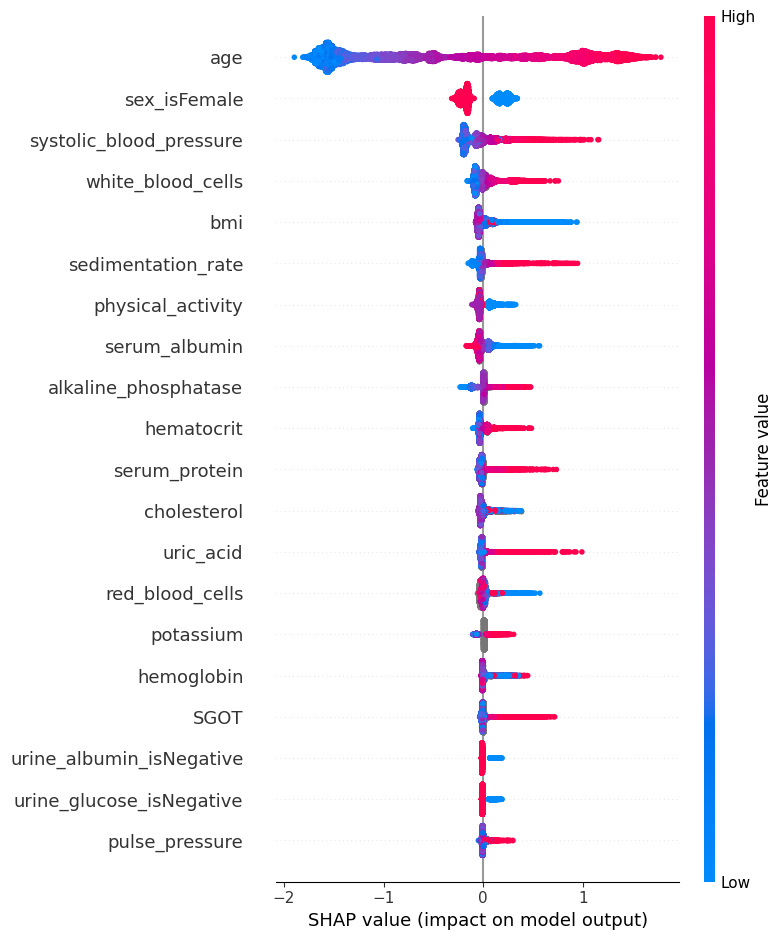

In [12]:
shap.summary_plot(shap_values, X)

## SHAP Dependence Plots
While a SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a person, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. Later we will see how to check that the interaction is really in the model with SHAP interaction values. Note that the row of a SHAP summary plot results from projecting the points of a SHAP dependence plot onto the y-axis, then recoloring by the feature itself.

Below we give the SHAP dependence plot for some of the NHANES I features, revealing interesting but expected trends. Keep in mind the calibration of some of these values can be different than a modern lab test so be careful drawing conclusions.

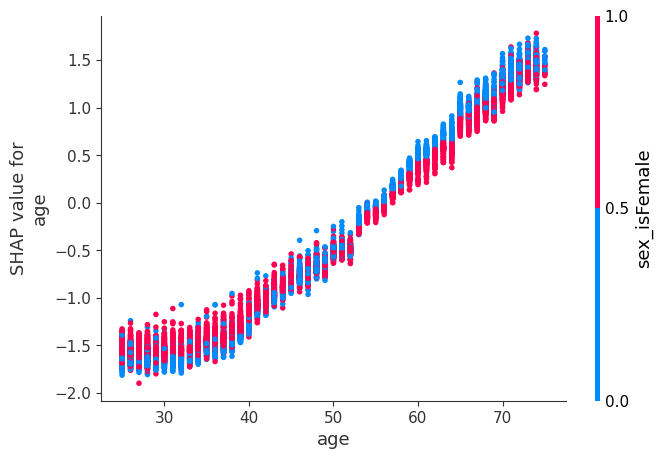

In [15]:
# we pass "Age" instead of an index because dependence_plot() will find it in X's column names for us
# sex_isFemale was automatically chosen for coloring based on a potential interaction to check that
# the interaction is really in the model see SHAP interaction values below
shap.dependence_plot("age", shap_values, X)

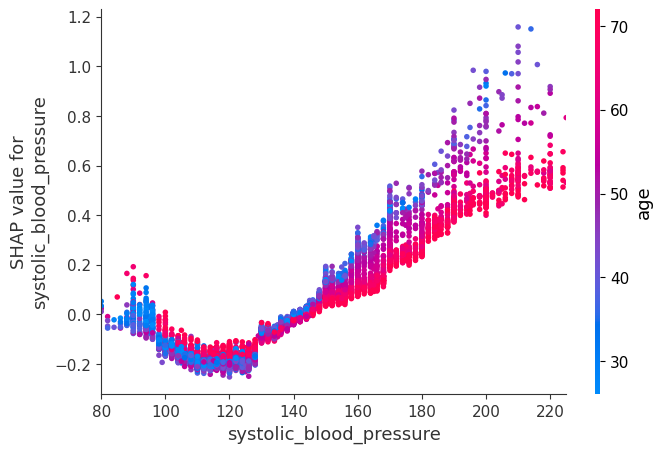

In [24]:
# argument show=False allows us to continue customizing the matplotlib plot before displaying it
shap.dependence_plot("systolic_blood_pressure", shap_values, X, show=False)
plt.xlim(80, 225)
plt.show()

## Compute SHAP Interaction Values
SHAP interaction values expand on regular SHAP values to consider the combined impact of multiple features. In XGBoost, the `pred_interactions` option calculates these values. It gives a matrix for each prediction: individual feature effects are on the diagonal, and combined effects of feature pairs are elsewhere. These interaction values show how feature pairs influence the prediction differently than each feature would alone. The matrix's total equals the change in prediction from the expected value. Interaction values are halved in the matrix since each pair appears twice, but are doubled when displayed to reflect their full impact.

In [25]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:2000,:])

[09:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


## SHAP Interaction Value Summary Plot
A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

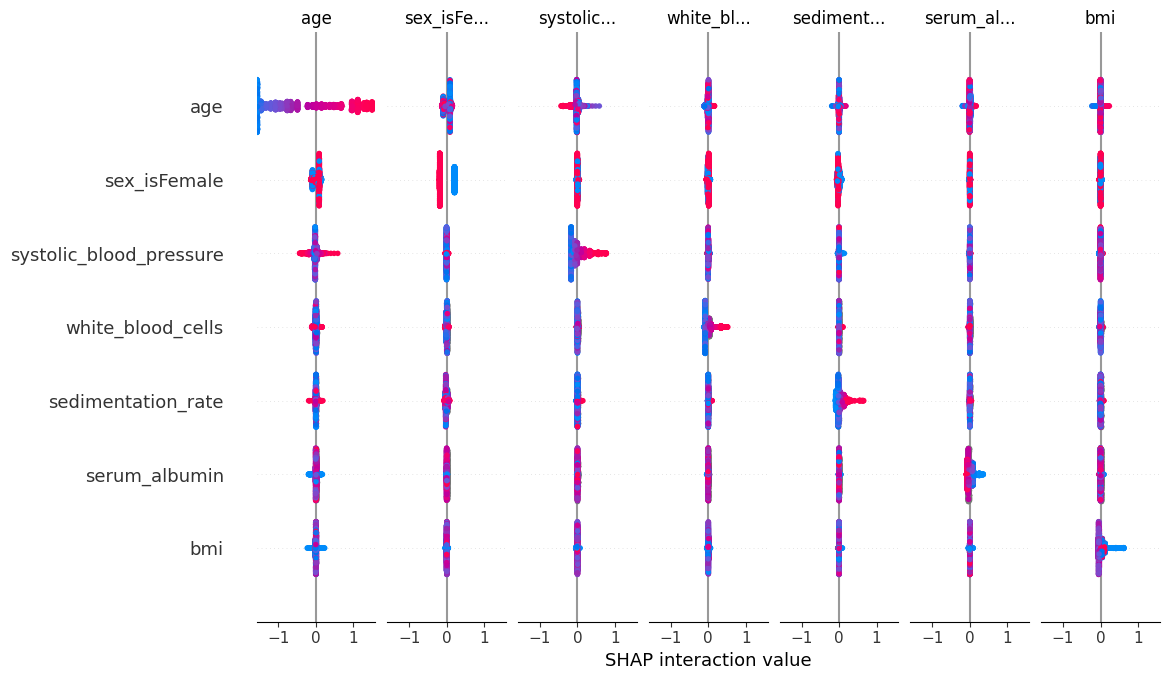

In [26]:
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])

## SHAP Interaction Value Dependence Plots

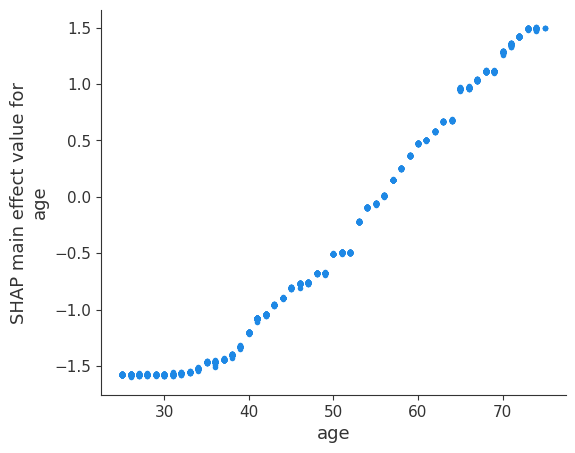

In [28]:
shap.dependence_plot(
    ("age", "age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

The plot you are seeing is a dependence plot. This type of plot is used to visualize the effect of a single feature (in this case, 'age') on the prediction model's output, both on its own (main effect) and in interaction with another feature. Here, the 'age' feature is being compared with itself to show its main effect.

This might seem a bit confusing at first—why compare 'age' with 'age'? The reason is to isolate the main effect of 'age' without the influence of interactions with other features. In a typical SHAP interaction plot, you would compare two different features to see how they interact, but when you specify the same feature twice, you effectively get a plot of just the main effects of that feature.

In the plot:

- The x-axis represents the value of 'age'.
- The y-axis represents the SHAP main effect value for 'age', which indicates the impact of 'age' on the model's output.

The plot does not show vertical dispersion (points spread out vertically) around the line because it is not showing interaction effects with other features—any interaction effects of 'age' with other features are captured elsewhere in the full interaction matrix. In a full SHAP interaction plot with different features compared, you would see points dispersed vertically, indicating varying interaction effects.

Now we plot the interaction effects involving age. These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above. The plot below involving age and sex shows that the sex-based death risk gap varies by age and peaks at age 60.

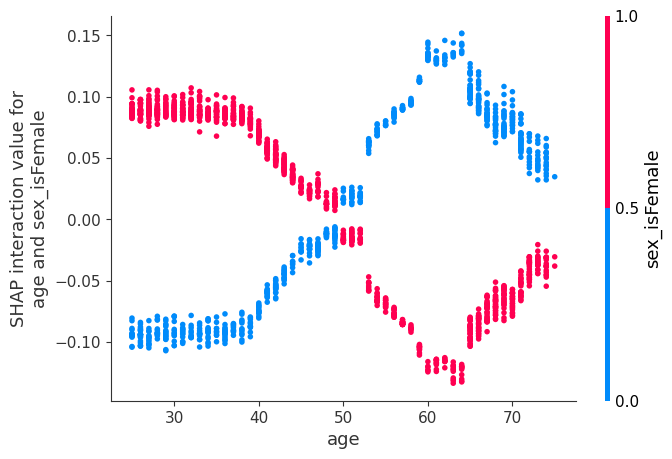

In [29]:
shap.dependence_plot(
    ("age", "sex_isFemale"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

Here's a breakdown of what this plot is illustrating:

- The x-axis represents the age of individuals.
- The y-axis represents the SHAP interaction values between age and being female.
- The color scale on the right indicates the sex of the individual, with blue representing male (since 'sex_isFemale' is 0) and red representing female ('sex_isFemale' is 1).

In this plot, each point represents an individual data point from the dataset. The vertical position of the points shows the impact of the interaction between age and the individual's sex on the model's output. The color coding allows you to see the difference in interaction effect based on the sex of the individual:

- Blue points (males) and red points (females) are distributed across the age axis, allowing you to see how age interacts with sex to affect the model's predictions.


What we can infer from the plot:

- The interaction effect varies with age, which suggests that the importance of being female in the model's predictions changes across different ages.
- There seems to be a pattern or trend in how the interaction effects vary with age, perhaps indicating that certain ages are more influential when combined with the individual's sex in the context of the model's predictions.

This type of visualization is useful for understanding how two features—age and sex—affect the predictions of a machine learning model in conjunction. It helps to identify if there are certain age ranges where being female has a stronger or weaker interaction effect on the output of the model.

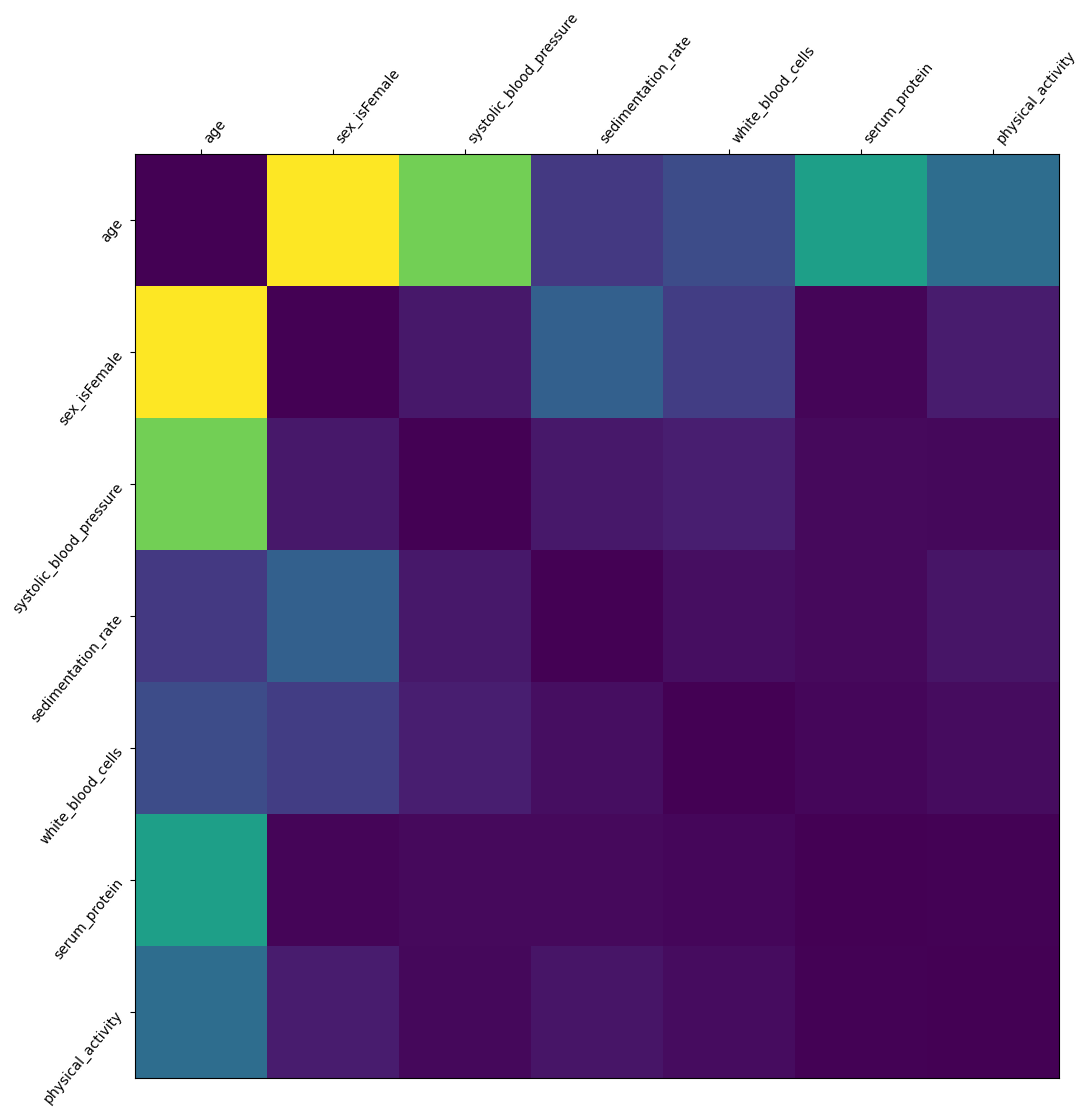

In [39]:
#Computing the sum of the absolute values of the SHAP
#interaction values across the first axis (rows), which results in
#a measure of the importance of each feature interaction for the
#model's predictions.
tmp = np.abs(shap_interaction_values).sum(0)

#he loop iterates over each feature and zeroes out the diagonal
#of the matrix. This is because the diagonal represents the
#interaction of each feature with itself, which is not relevant
#for off-diagonal interaction effects.
for i in range(tmp.shape[0]):
    tmp[i, i] = 0

# This line finds the indices of the top 7 features with the
#highest summed absolute SHAP interaction values, effectively
#selecting the most important interactions.
inds = np.argsort(-tmp.sum(0))[:7]

# The tmp2 matrix is a subset of the tmp matrix, containing only
#the rows and columns for the top 7 features. This is the data that
#will be visualized in the heatmap.
tmp2 = tmp[inds, :][:, inds]

plt.figure(figsize=(12, 12))

# Displays tmp2 as an image, i.e., a heatmap where the colors
# represent the magnitude of the SHAP interaction values.
plt.imshow(tmp2)

plt.yticks(range(tmp2.shape[0]),
           X.columns[inds],
           rotation=50.4,
           horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]),
           X.columns[inds],
           rotation=50.4,
           horizontalalignment="left")
plt.gca().xaxis.tick_top()
plt.show()

The goal of the heatmap is to visualize the magnitude of interaction effects between different pairs of features in a predictive model. Here's a step-by-step explanation of what the code does:

1. It computes the sum of absolute SHAP interaction values across each row, which provides a measure of how much each feature interaction contributes to the model's output.

2. It then creates a temporary matrix where it zeroes out the diagonal elements. This is because the diagonal elements represent the main effect of each feature, which is not relevant when we are interested in the interaction effects between different features.

3. It identifies the top 7 features with the highest summed absolute interaction values. These are considered the most important interactions in terms of influencing the model's predictions.

4. A submatrix is created, tmp2, which includes only the rows and columns corresponding to these top 7 features. This submatrix will be visualized in the heatmap.

5. Finally, a heatmap is created as an image, where the color intensity represents the magnitude of the SHAP interaction values between pairs of features. The features are labeled on both axes, and the color scale provides a visual cue for interpreting the strength of the interactions.

The generated heatmap helps to quickly identify which pairs of features have the strongest interaction effects on the model's predictions, thus offering insights into complex relationships within the data that a simple analysis of main effects might miss. This can be particularly useful for feature engineering, model interpretation, and identifying potential areas where the model may be sensitive to feature interactions.





